## Setting Up:

In [ ]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import config
import massbalancemachine as mbm
from collections import defaultdict
import logging
from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.xgb_helpers import *
import geopandas as gpd

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = config.SwitzerlandConfig()

In [ ]:
seed_all(cfg.seed)
free_up_cuda()
custom_working_dir = '../../../data/OGGM/'

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'
color_winter = '#a6cee3'
color_annual = '#1f78b4'

In [3]:
# RGI Ids:
# Read rgi ids:
rgi_df = pd.read_csv(path_glacier_ids, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)

# Specify the short names of the climate variables available in the dataset
# vois_climate = [
#     't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
# ]

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "aspect_sgi",
    "slope_sgi",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

## Read GL data:

In [4]:
# Read stakes data over all glaciers:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_all.csv')

print('Number of glaciers:', len(data_glamos['GLACIER'].unique()))
print('Number of winter and annual samples:', len(data_glamos))
print('Number of annual samples:',
      len(data_glamos[data_glamos.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_glamos[data_glamos.PERIOD == 'winter']))

# Capitalize glacier names:
glacierCap = {}
for gl in data_glamos['GLACIER'].unique():
    if gl == 'claridenU':
        glacierCap[gl] = 'Clariden_U'
    elif gl == 'claridenL':
        glacierCap[gl] = 'Clariden_L'
    else:
        glacierCap[gl] = gl.capitalize()

data_glamos.head(2)

Number of glaciers: 31
Number of winter and annual samples: 31875
Number of annual samples: 7587
Number of winter samples: 24288


,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,RGIId,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v,aspect_sgi,slope_sgi,topo_sgi
0,2006,adler_28,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,RGI60-11.02764,254.483669,19.483581,3039.0,-1.504815,43.181839,3.591626,286.843880,20.604390,3018.033333
1,2006,adler_54,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,RGI60-11.02764,273.466595,12.549861,3091.0,-0.970061,41.090096,0.975349,258.181463,12.582387,3077.711111


### All glaciers:

Text(0.5, 1.0, 'Number of total measurements per glacier since 1951')

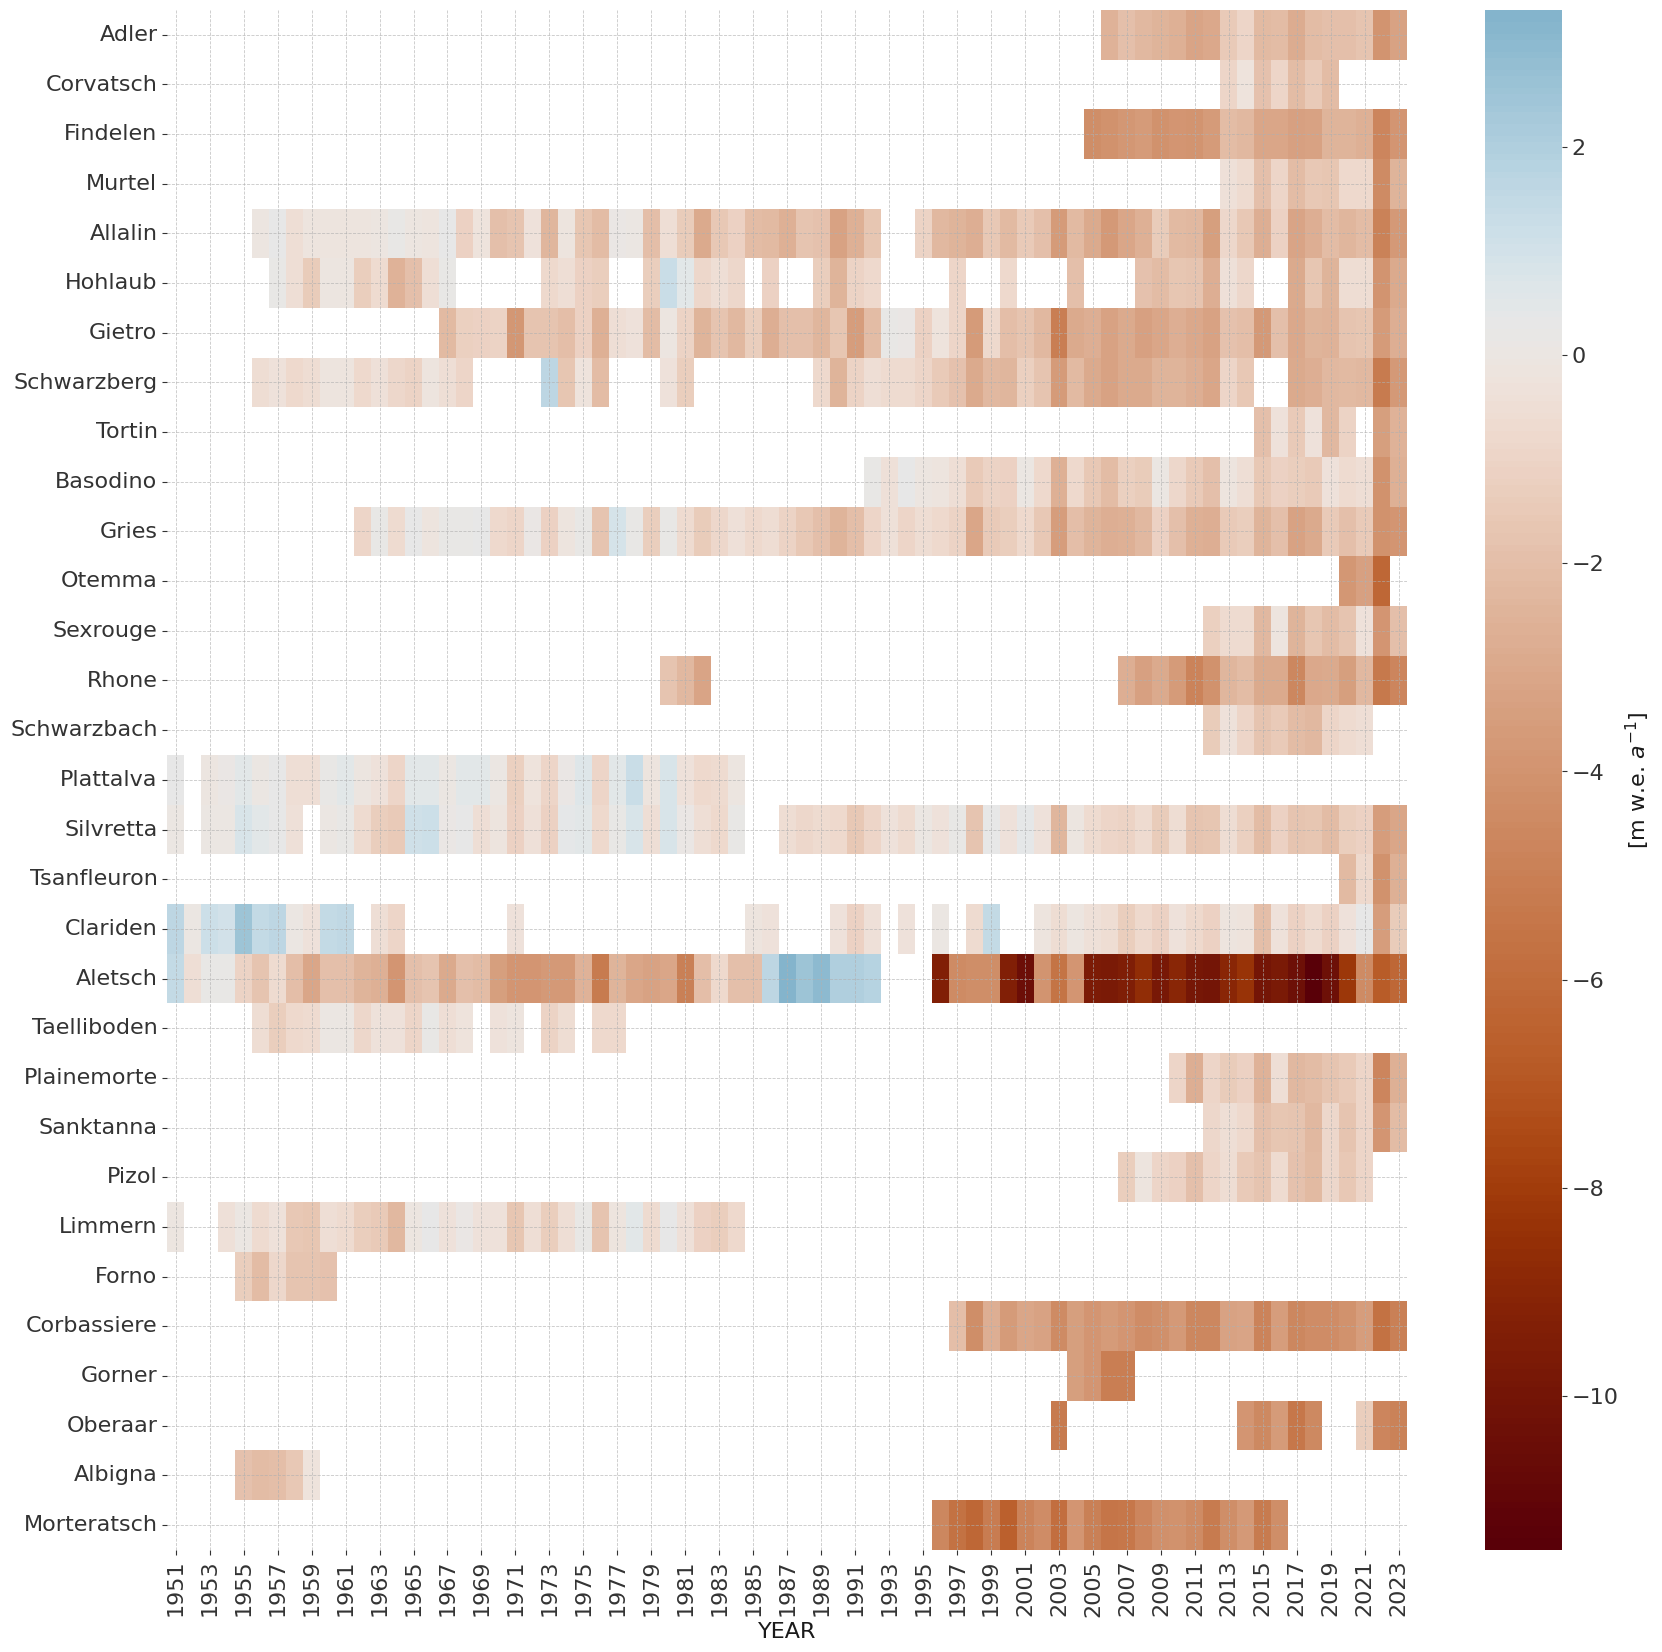

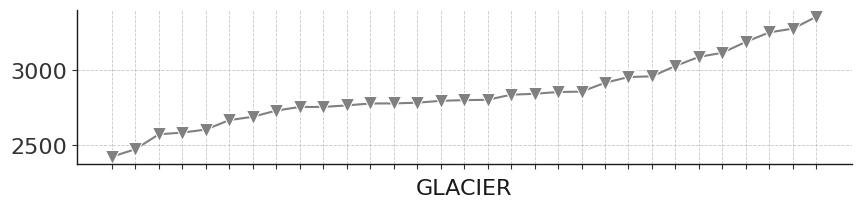

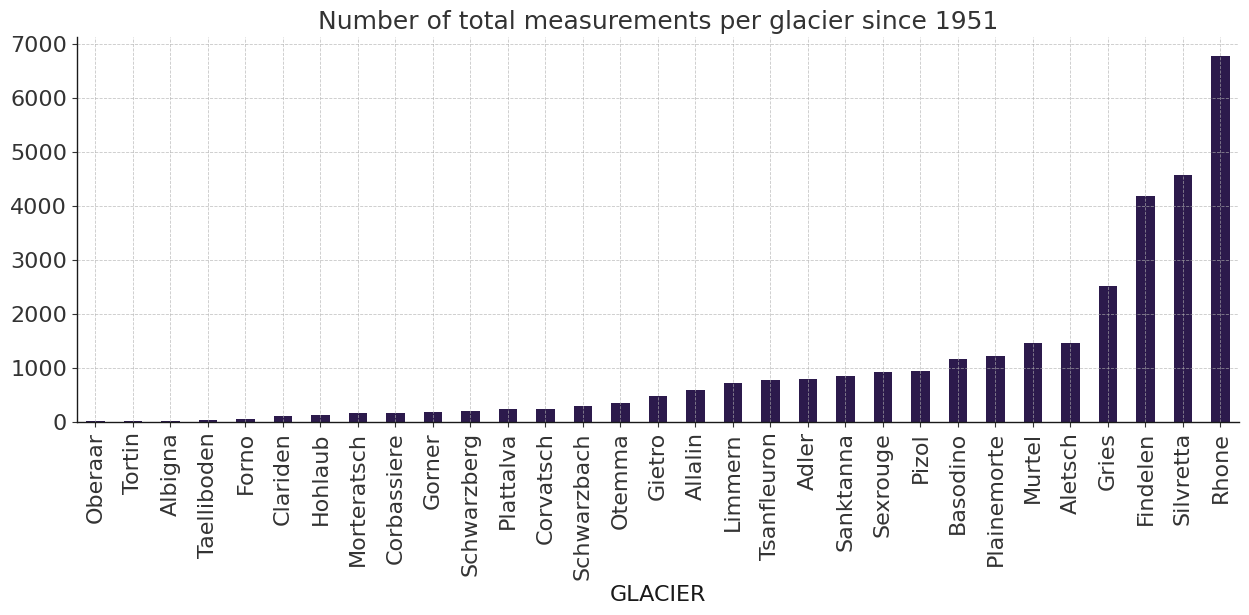

In [5]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier
data_glamos_ = data_glamos.copy()
data_glamos_['GLACIER'] = data_glamos.GLACIER.apply(lambda x: glacierCap[x])
mean_mb_per_glacier = data_glamos_.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] ==
                                          'annual']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_glamos_.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
gl_per_el = gl_per_el.sort_values(ascending=False)
matrix = matrix.loc[gl_per_el.index]

# make index categorical
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)
fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(1, 1, 1)
sns.heatmap(data=matrix,
            center=0,
            cmap=cm.vik_r,
            cbar_kws={'label': '[m w.e. $a^{-1}$]'},
            ax=ax)

# Plot elevation:
fig = plt.figure(figsize=(10, 2))
ax = plt.subplot(1, 1, 1)
sns.lineplot(gl_per_el.sort_values(ascending=True),
             ax=ax,
             color='gray',
             marker='v')
ax.set_xticklabels('', rotation=90)
ax.set_ylabel('')

fig = plt.figure(figsize=(10, 2))
num_gl = data_glamos_.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', figsize=(15, 5), cmap=cm.devon)
plt.title('Number of total measurements per glacier since 1951')


### Glaciers with pot. radiadation data:

In [6]:
# Glaciers with data of potential clear sky radiation
# Format to same names as stakes:
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_pcsr+'csv/')
]
glDirect.sort()

restgl = Diff(list(glDirect), list(data_glamos.GLACIER.unique()))
restgl.sort()
print('Glaciers with potential clear sky radiation data:\n', glDirect)
print('Number of glaciers:', len(glDirect))
print('Glaciers without potential clear sky radiation data:\n', restgl)

# Filter out glaciers without data:
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]

# Look at the data of the ERA5 dataset:
xr.open_dataset(path_ERA5_raw + 'era5_monthly_averaged_data.nc')

Glaciers with potential clear sky radiation data:
 ['adler', 'albigna', 'aletsch', 'allalin', 'arolla', 'basodino', 'clariden', 'corbassiere', 'corvatsch', 'findelen', 'forno', 'gietro', 'gorner', 'gries', 'hohlaub', 'joeri', 'limmern', 'morteratsch', 'murtel', 'oberaar', 'otemma', 'pers', 'pizol', 'plainemorte', 'plattalva', 'rhone', 'sanktanna', 'schwarzbach', 'schwarzberg', 'sexrouge', 'silvretta', 'taelliboden', 'tortin', 'tsanfleuron']
Number of glaciers: 34
Glaciers without potential clear sky radiation data:
 ['arolla', 'joeri', 'pers']


<xarray.Dataset> Size: 2GB
Dimensions:    (longitude: 201, latitude: 51, expver: 2, time: 895)
Coordinates:
  * longitude  (longitude) float32 804B 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9 20.0
  * latitude   (latitude) float32 204B 50.0 49.9 49.8 49.7 ... 45.2 45.1 45.0
  * expver     (expver) int32 8B 1 5
  * time       (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2024-07-01
Data variables: (12/14)
    u10        (time, expver, latitude, longitude) float64 147MB ...
    v10        (time, expver, latitude, longitude) float64 147MB ...
    t2m        (time, expver, latitude, longitude) float64 147MB ...
    fal        (time, expver, latitude, longitude) float64 147MB ...
    snowc      (time, expver, latitude, longitude) float64 147MB ...
    rsn        (time, expver, latitude, longitude) float64 147MB ...
    ...         ...
    smlt       (time, expver, latitude, longitude) float64 147MB ...
    slhf       (time, expver, latitude, longitude) float64 147MB ...
    str        (time, expver, latitude, longitude) float64 147MB ...
    sshf       (time, expver, latitude, longitude) float64 147MB ...
    ssrd       (time, expver, latitude, longitude) float64 147MB ...
    tp         (time, expver, latitude, longitude) float64 147MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-08 11:30:10 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

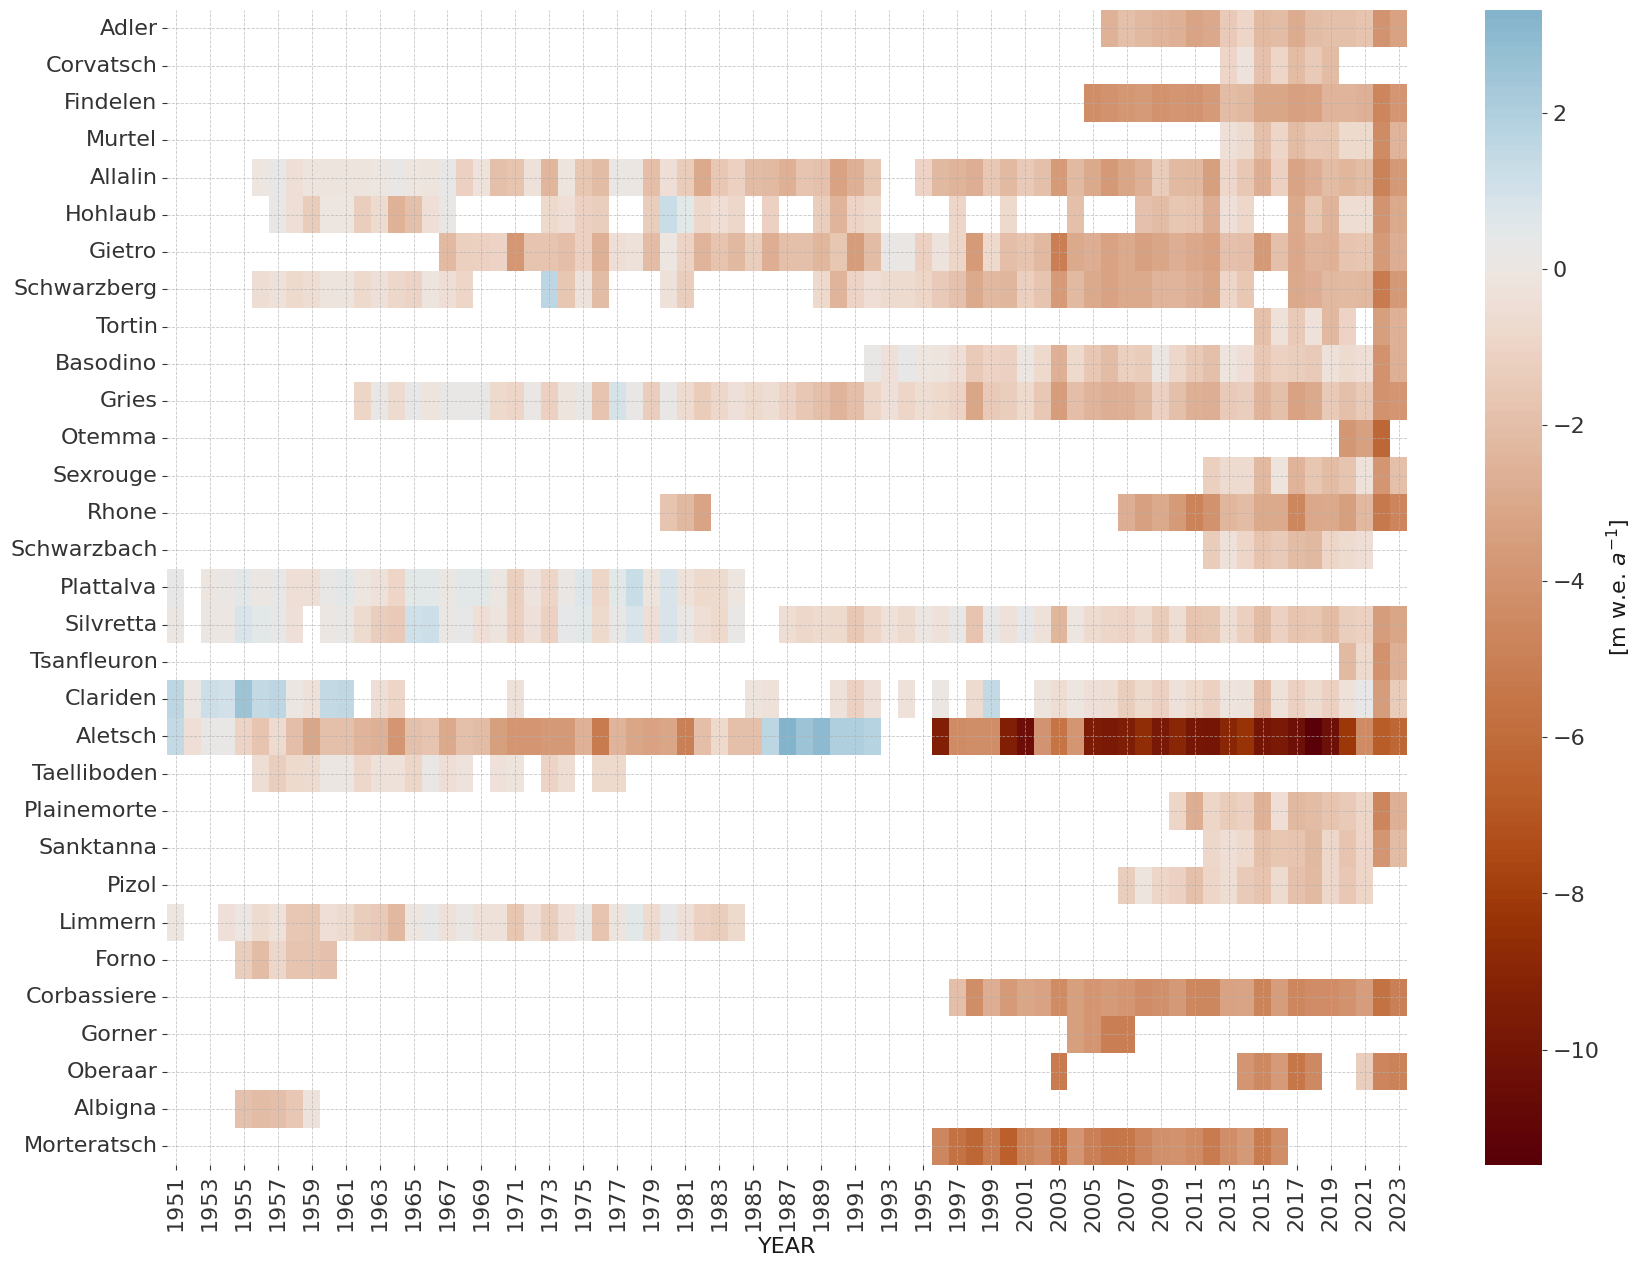

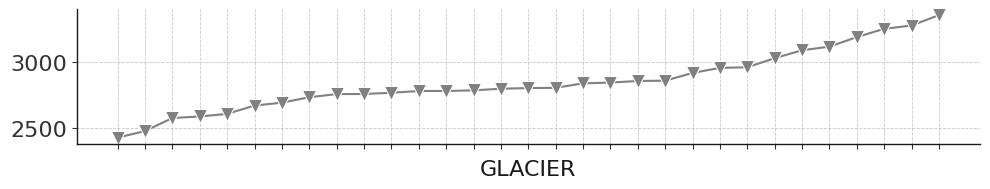

In [7]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier
data_glamos_ = data_glamos.copy()
data_glamos_['GLACIER'] = data_glamos['GLACIER'].apply(lambda x: glacierCap[x])

mean_mb_per_glacier = data_glamos_.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] ==
                                          'annual']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_glamos_.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
gl_per_el = gl_per_el.sort_values(ascending=False)

# Order matrix:
matrix = matrix.loc[gl_per_el.index]
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)

# Plot heatmap:
fig = plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 1, 1)
heatmap = sns.heatmap(
    data=matrix,
    center=0,
    cmap=cm.vik_r,
    cbar_kws={'label': '[m w.e. $a^{-1}$]'},
    ax=ax,
)

# Plot elevation:
fig = plt.figure(figsize=(10, 2))
ax = plt.subplot(1, 1, 1)
sns.lineplot(gl_per_el.sort_values(ascending=True),
             ax=ax,
             color='gray',
             marker='v')
ax.set_xticklabels('', rotation=90)
ax.set_ylabel('')
plt.tight_layout()


## Input data:
### Input dataset:

In [ ]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')


def process_or_load_data(run_flag, data_glamos, paths, config, vois_climate,
                         vois_topographical):
    """
    Process or load the data based on the RUN flag.
    """
    if run_flag:
        logging.info("Number of annual and seasonal samples: %d",
                     len(data_glamos))

        # Filter data
        logging.info("Running on %d glaciers:\n%s",
                     len(data_glamos.GLACIER.unique()),
                     data_glamos.GLACIER.unique())

        # Create dataset
        dataset_gl = mbm.Dataset(cfg,
                                 data=data_glamos,
                                 region_name='CH',
                                 data_path=paths['csv_path'])
        logging.info("Number of winter and annual samples: %d",
                     len(data_glamos))
        logging.info("Number of annual samples: %d",
                     len(data_glamos[data_glamos.PERIOD == 'annual']))
        logging.info("Number of winter samples: %d",
                     len(data_glamos[data_glamos.PERIOD == 'winter']))

        # Add climate data
        logging.info("Adding climate features...")
        try:
            dataset_gl.get_climate_features(
                climate_data=paths['era5_climate_data'],
                geopotential_data=paths['geopotential_data'],
                change_units=True)
        except Exception as e:
            logging.error("Failed to add climate features: %s", e)
            return None

        # Add radiation data
        logging.info("Adding potential clear sky radiation...")
        logging.info("Shape before adding radiation: %s",
                     dataset_gl.data.shape)
        dataset_gl.get_potential_rad(paths['radiation_save_path'])
        logging.info("Shape after adding radiation: %s", dataset_gl.data.shape)

        # Convert to monthly resolution
        logging.info("Converting to monthly resolution...")
        dataset_gl.convert_to_monthly(meta_data_columns=cfg.metaData,
                                      vois_climate=vois_climate + ['pcsr'],
                                      vois_topographical=vois_topographical)

        # Create DataLoader
        dataloader_gl = mbm.DataLoader(cfg,
                                       data=dataset_gl.data,
                                       meta_data_columns=cfg.metaData)
        logging.info("Number of monthly rows: %d", len(dataloader_gl.data))
        logging.info("Columns in the dataset: %s", dataloader_gl.data.columns)

        # Save processed data
        output_file = os.path.join(paths['csv_path'],
                                   'CH_wgms_dataset_monthly_full.csv')
        dataloader_gl.data.to_csv(output_file, index=False)
        logging.info("Processed data saved to: %s", output_file)

        return dataloader_gl
    else:
        # Load preprocessed data
        try:
            input_file = os.path.join(paths['csv_path'],
                                      'CH_wgms_dataset_monthly_full.csv')
            data_monthly = pd.read_csv(input_file)
            dataloader_gl = mbm.DataLoader(cfg,
                                           data=data_monthly,
                                           meta_data_columns=cfg.metaData)
            logging.info("Loaded preprocessed data.")
            logging.info("Number of monthly rows: %d", len(dataloader_gl.data))
            logging.info(
                "Number of annual rows: %d",
                len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
            logging.info(
                "Number of winter rows: %d",
                len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

            return dataloader_gl
        except FileNotFoundError as e:
            logging.error("Preprocessed data file not found: %s", e)
            return None

In [9]:
RUN = False

paths = {
    'csv_path': path_PMB_GLAMOS_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure.nc',
    'radiation_save_path': path_pcsr+'csv/'
}

dataloader_gl = process_or_load_data(run_flag=RUN,
                                     data_glamos=data_glamos,
                                     paths=paths,
                                     config=config,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical)
data_monthly = dataloader_gl.data

2025-02-04 10:10:48,117 - INFO - Loaded preprocessed data.
2025-02-04 10:10:48,118 - INFO - Number of monthly rows: 280720
2025-02-04 10:10:48,142 - INFO - Number of annual rows: 90870
2025-02-04 10:10:48,172 - INFO - Number of winter rows: 189850


### Correction for elevation difference:

Mean Cprec: 2.3, Mean T_off: 2.03


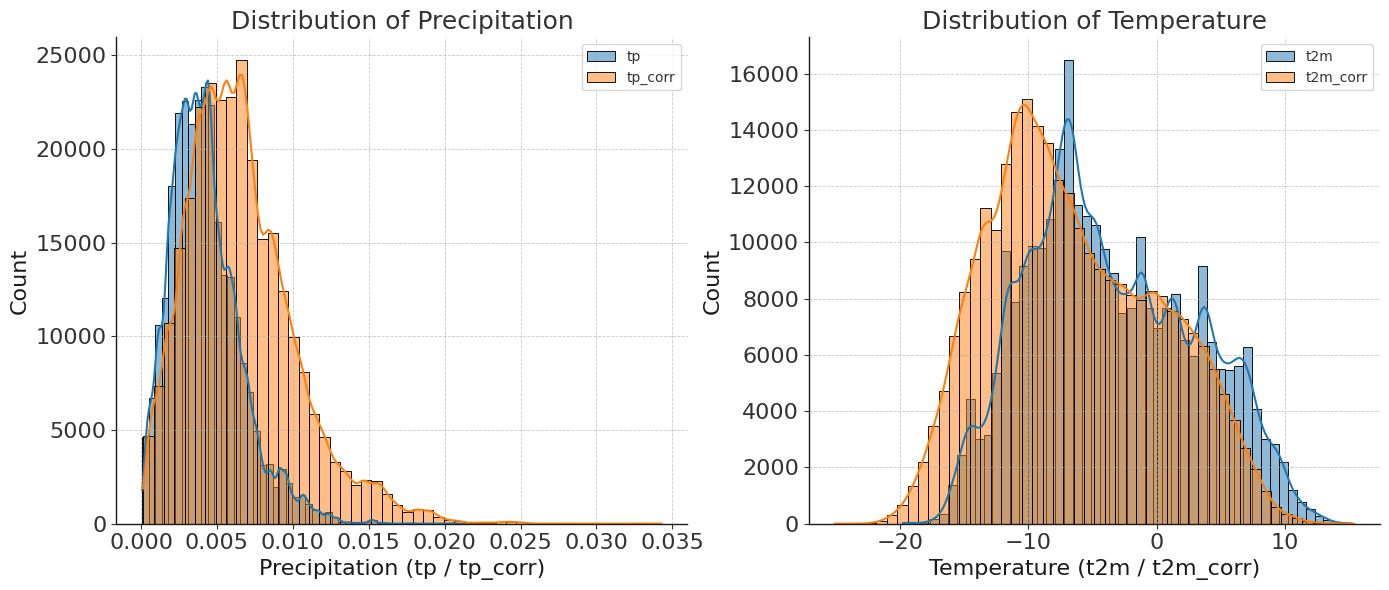

In [10]:
# Load and preprocess GloGEM factors
path_glogem_factors = os.path.join(path_glogem, 'reference_run_GloGEM2024.csv')
glogem_factors = pd.read_csv(path_glogem_factors)
glogem_factors.rename(columns={'ID': 'RGIId'}, inplace=True)
glogem_factors['RGIId'] = glogem_factors['RGIId'].apply(
    lambda x: format_rgi_code(x))

c_prec_dic, t_off_dic = {}, {}
for gl in data_monthly.GLACIER.unique():
    rgi_gl = data_monthly[data_monthly.GLACIER == gl].RGIId.unique()[0]
    factor_gl = glogem_factors[glogem_factors.RGIId == rgi_gl]
    c_prec_dic[gl] = factor_gl['Cprec'].values[0]
    t_off_dic[gl] = factor_gl['T_off'].values[0]

# Mean of dic values
mean_c_prec = np.max(list(c_prec_dic.values()))
mean_t_off = np.max(list(t_off_dic.values()))
print(f"Mean Cprec: {mean_c_prec}, Mean T_off: {mean_t_off}")

# Correct t2m and tp for elevation
dataloader_gl.correct_for_elevation(gl_specific=False)

# Plot the distribution of corrected and uncorrected precipitation and temperature
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Precipitation
sns.histplot(data_monthly['tp'],
             bins=50,
             kde=True,
             label='tp',
             alpha=0.5,
             ax=axes[0])
sns.histplot(data_monthly['tp_corr'],
             bins=50,
             kde=True,
             label='tp_corr',
             alpha=0.5,
             ax=axes[0])
axes[0].set_title('Distribution of Precipitation')
axes[0].set_xlabel('Precipitation (tp / tp_corr)')
axes[0].legend()

# Temperature
sns.histplot(data_monthly['t2m'],
             bins=50,
             kde=True,
             label='t2m',
             alpha=0.5,
             ax=axes[1])
sns.histplot(data_monthly['t2m_corr'],
             bins=50,
             kde=True,
             label='t2m_corr',
             alpha=0.5,
             ax=axes[1])
axes[1].set_title('Distribution of Temperature')
axes[1].set_xlabel('Temperature (t2m / t2m_corr)')
axes[1].legend()

plt.tight_layout()
plt.show()

### Feature correlation:

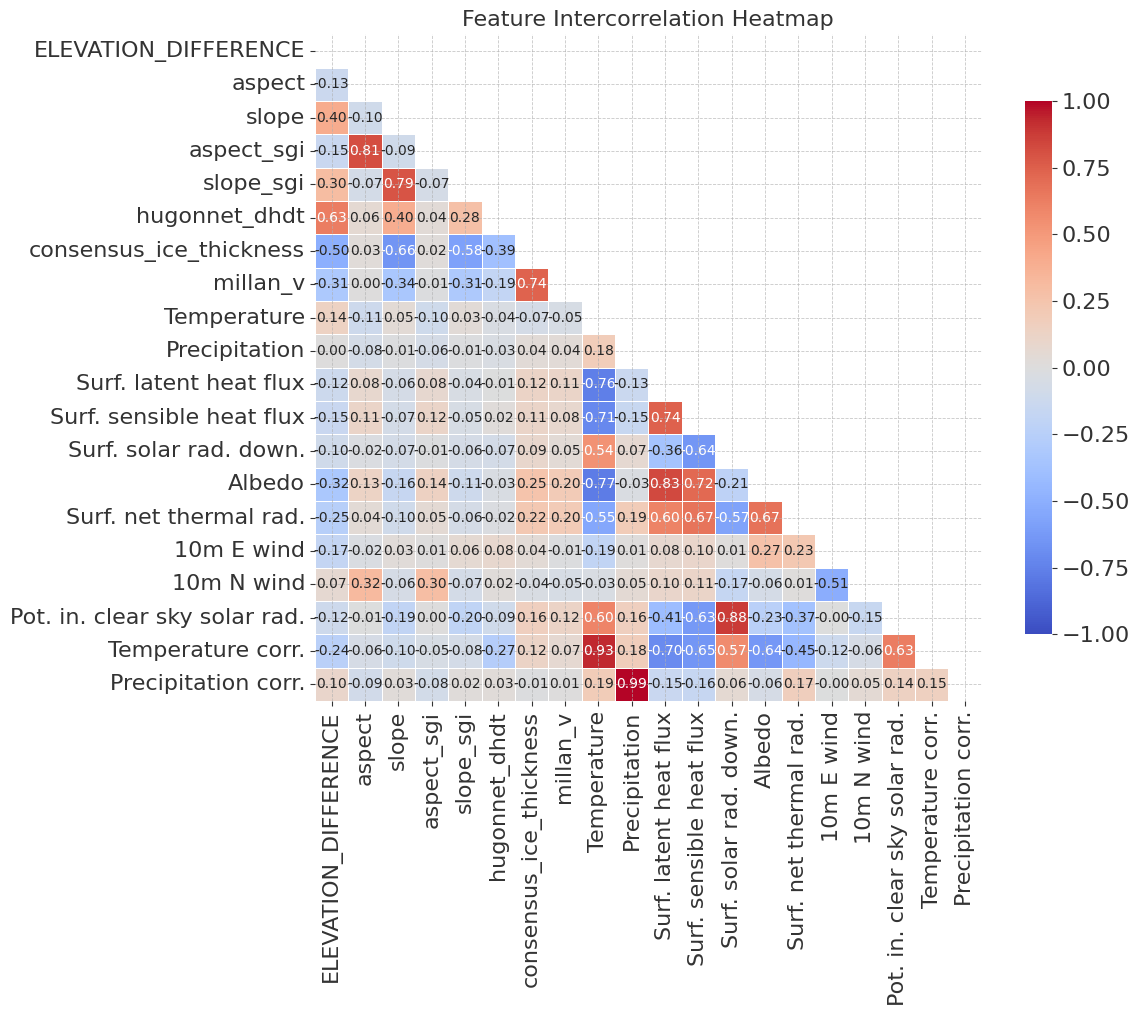

In [11]:
# Prepare data for correlation analysis
df = dataloader_gl.data.copy().dropna()

# Define the columns to keep
columns_to_keep = [
    col for col in df.columns if col not in [
        'GLACIER', 'PERIOD', 'YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE',
        'ALTITUDE_CLIMATE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
        'N_MONTHS', 'MONTHS'
    ]
]
df = df[columns_to_keep]

# Rename columns based on long names (if applicable)
df.rename(columns=vois_climate_long_name, inplace=True)

# Compute correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    vmax=1,
    vmin=-1,
    center=0,
    annot=True,  # Add correlation values
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.8})

# Enhance readability
plt.title("Feature Intercorrelation Heatmap", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

### Num. meas per year:

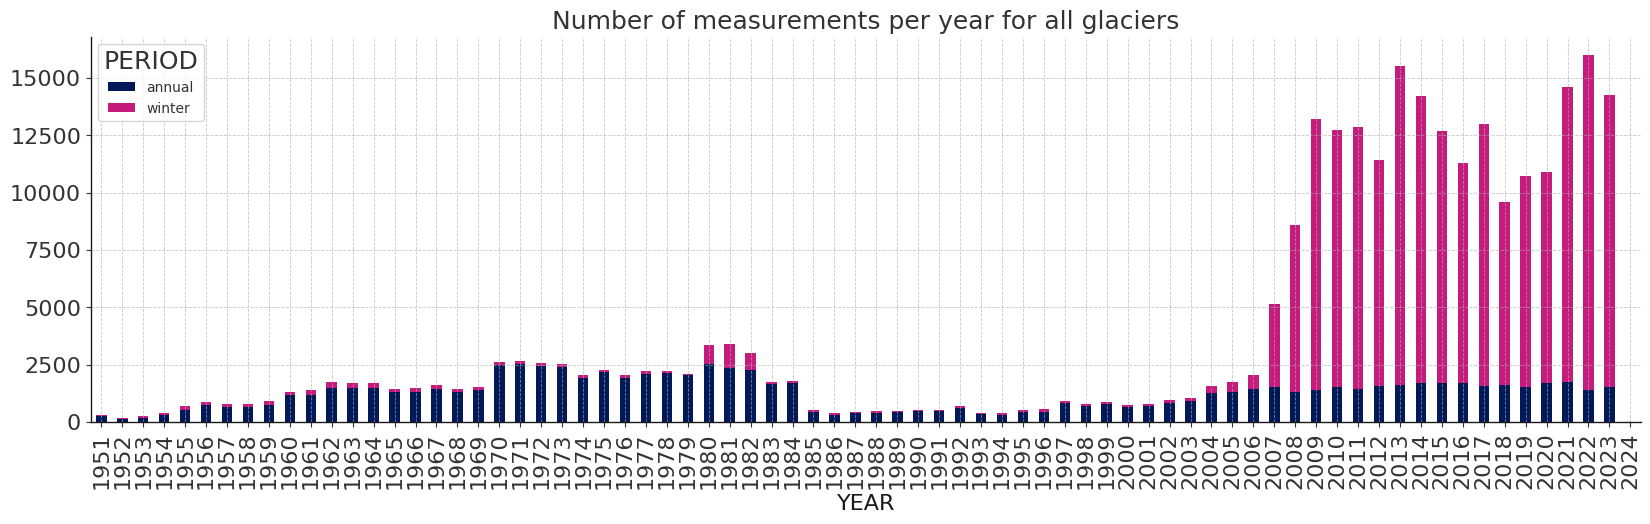

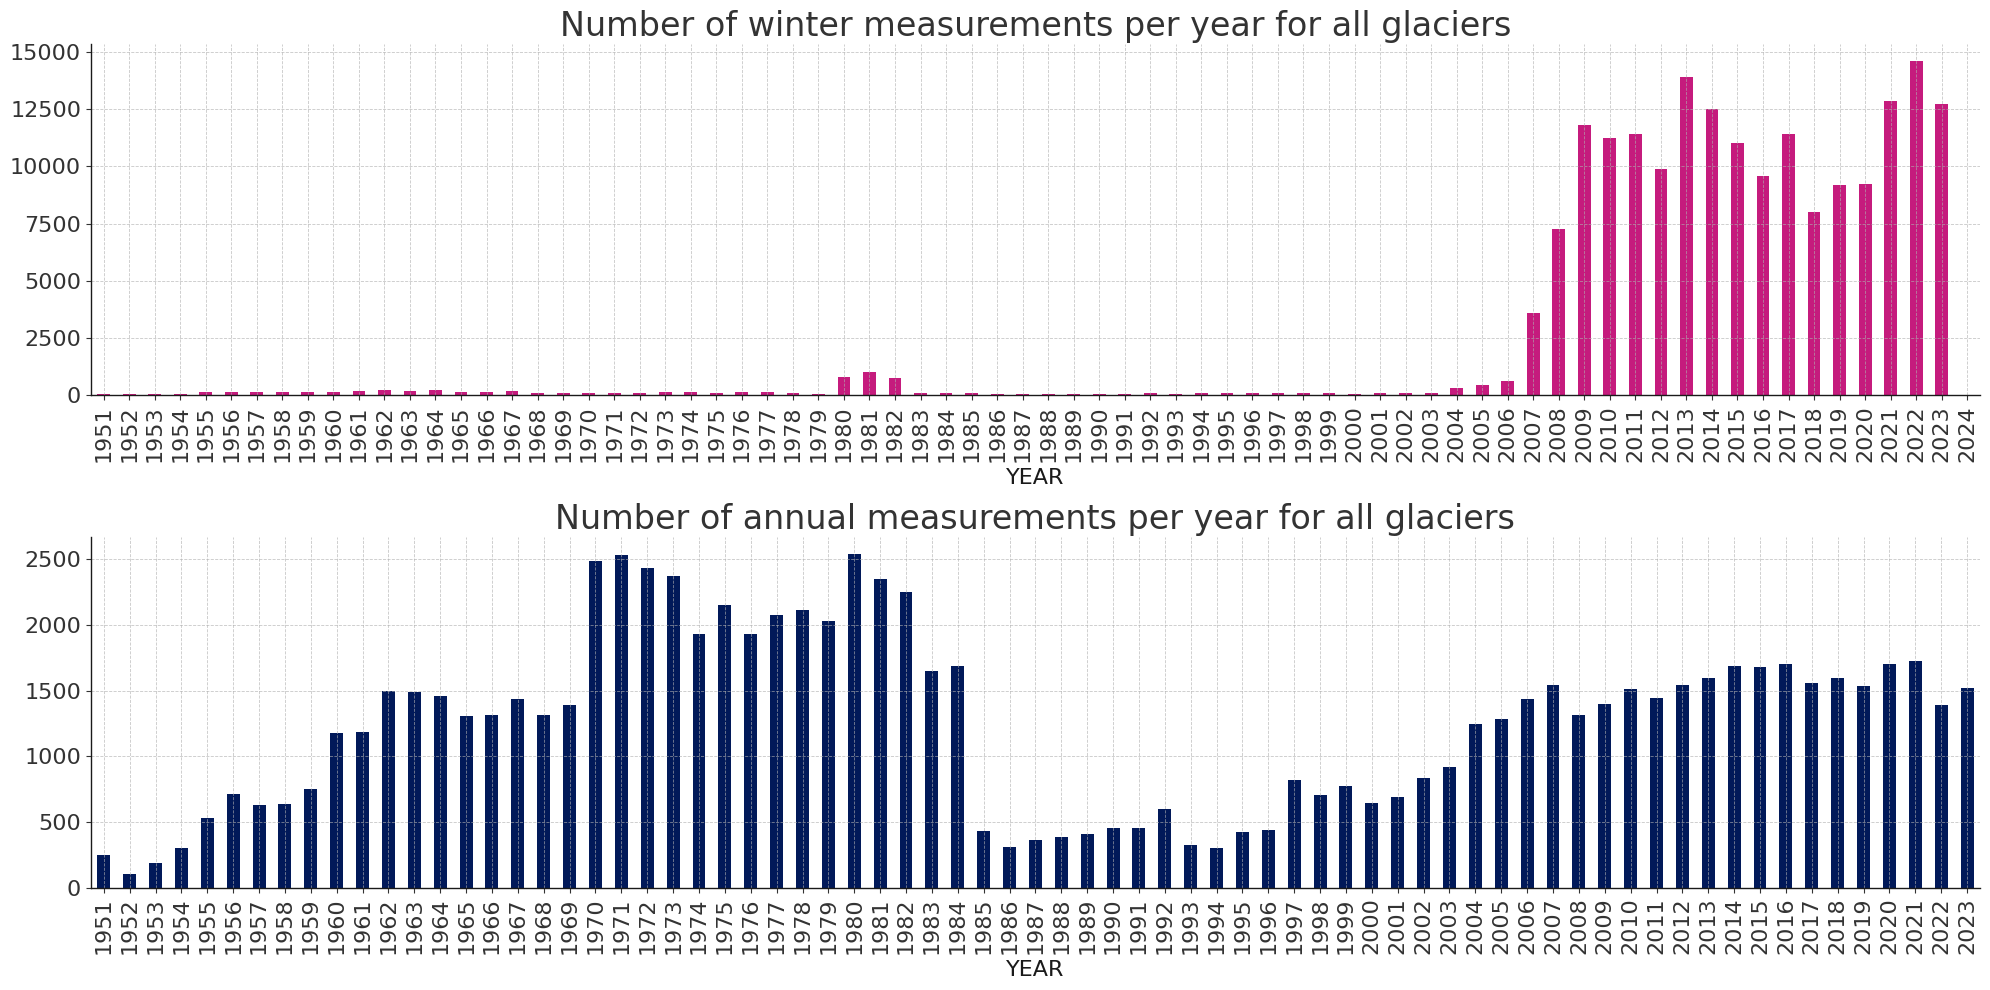

In [12]:
# Number of measurements per year:
dataloader_gl.data.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_pink])
plt.title('Number of measurements per year for all glaciers')

# Plot winter and annual separately:
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharey=False)
dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              ax=axs[0],
                                              color=[color_pink],
                                              legend=False)
axs[0].set_title('Number of winter measurements per year for all glaciers',
                 fontsize=24)

dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              stacked=True,
                                              ax=axs[1],
                                              color=[color_dark_blue],
                                              legend=False)
axs[1].set_title('Number of annual measurements per year for all glaciers',
                 fontsize=24)
plt.tight_layout()

### Sanity checks:

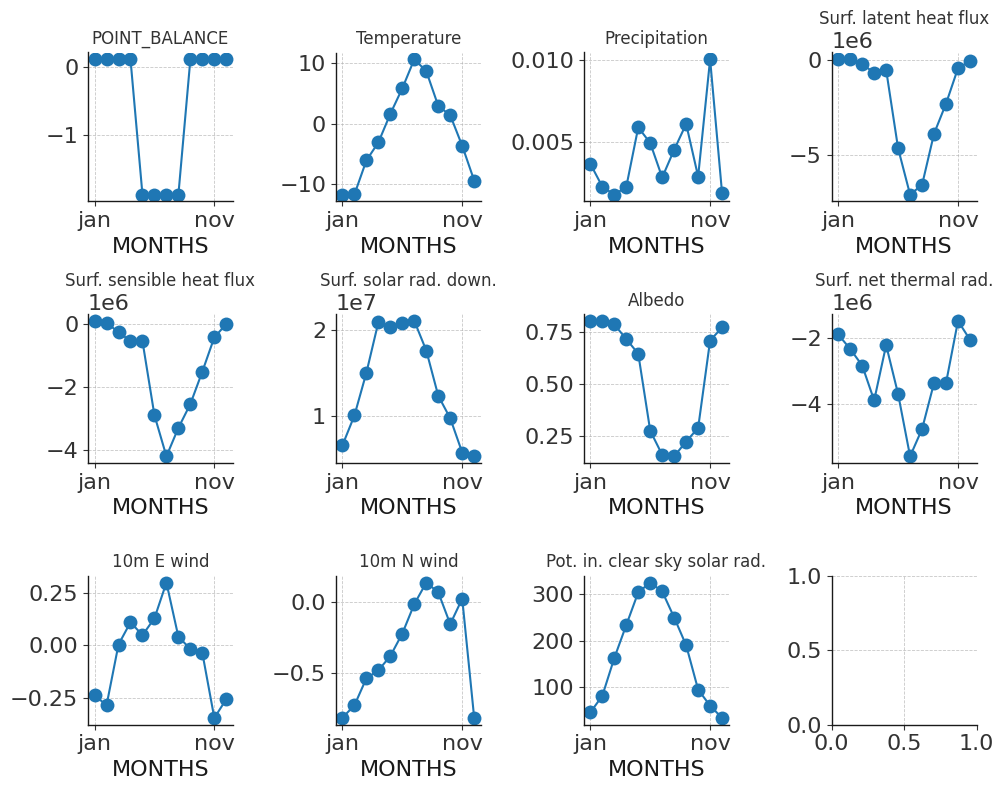

In [13]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate + ['pcsr']
df = df[(df.GLACIER == 'corvatsch') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

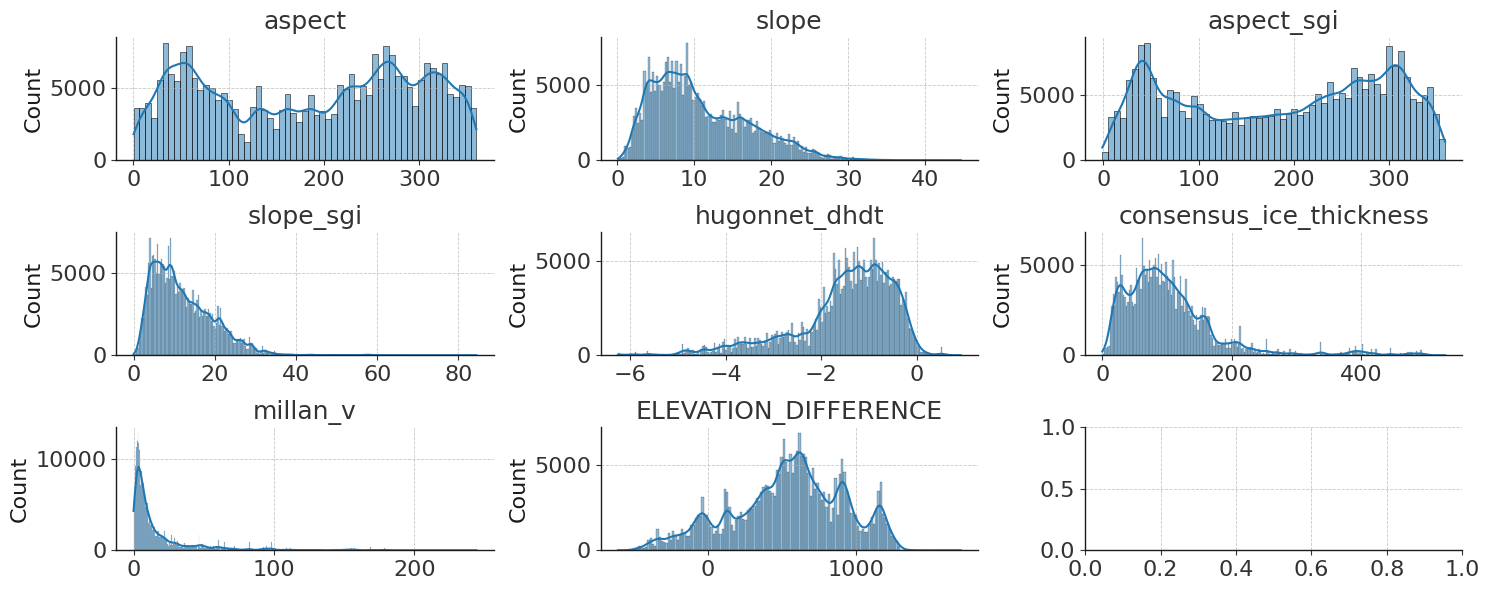

In [14]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

## Blocking on glaciers:

In [15]:
test_glaciers = [
    'tortin', 'plattalva', 'sanktanna', 'schwarzberg', 'hohlaub', 'pizol',
    'joeri', 'corvatsch', 'tsanfleuron'
]
train_glaciers = [
    i for i in dataloader_gl.data.GLACIER.unique() if i not in test_glaciers
]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))

test_perc = (len(data_test) / len(data_train)) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))

# Number of annual versus winter measurements:
print('Train:')
print('Number of winter and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))

# Same for test
print('Test:')
print('Number of winter and annual samples:', len(data_test))
print('Number of annual samples:',
      len(data_test[data_test.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_test[data_test.PERIOD == 'winter']))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

Size of test data: 28420
Size of train data: 252300
Percentage of test size: 11.26%
Train:
Number of winter and annual samples: 252300
Number of annual samples: 83536
Number of winter samples: 168764
Test:
Number of winter and annual samples: 28420
Number of annual samples: 7334
Number of winter samples: 21086
Total:
Number of monthly rows: 280720
Number of annual rows: 90870
Number of winter rows: 189850


In [16]:
data_test['GLACIER_new'] = data_test['POINT_ID'].apply(
    lambda x: x.split('_')[0])
data_test['GLACIER_new'].unique()

array(['corvatsch', 'hohlaub', 'pizol', 'plattalva', 'sanktanna',
       'schwarzberg', 'tortin', 'tsanfleuron'], dtype=object)

#### Heatmap annual:

KeyError: 'joeri'

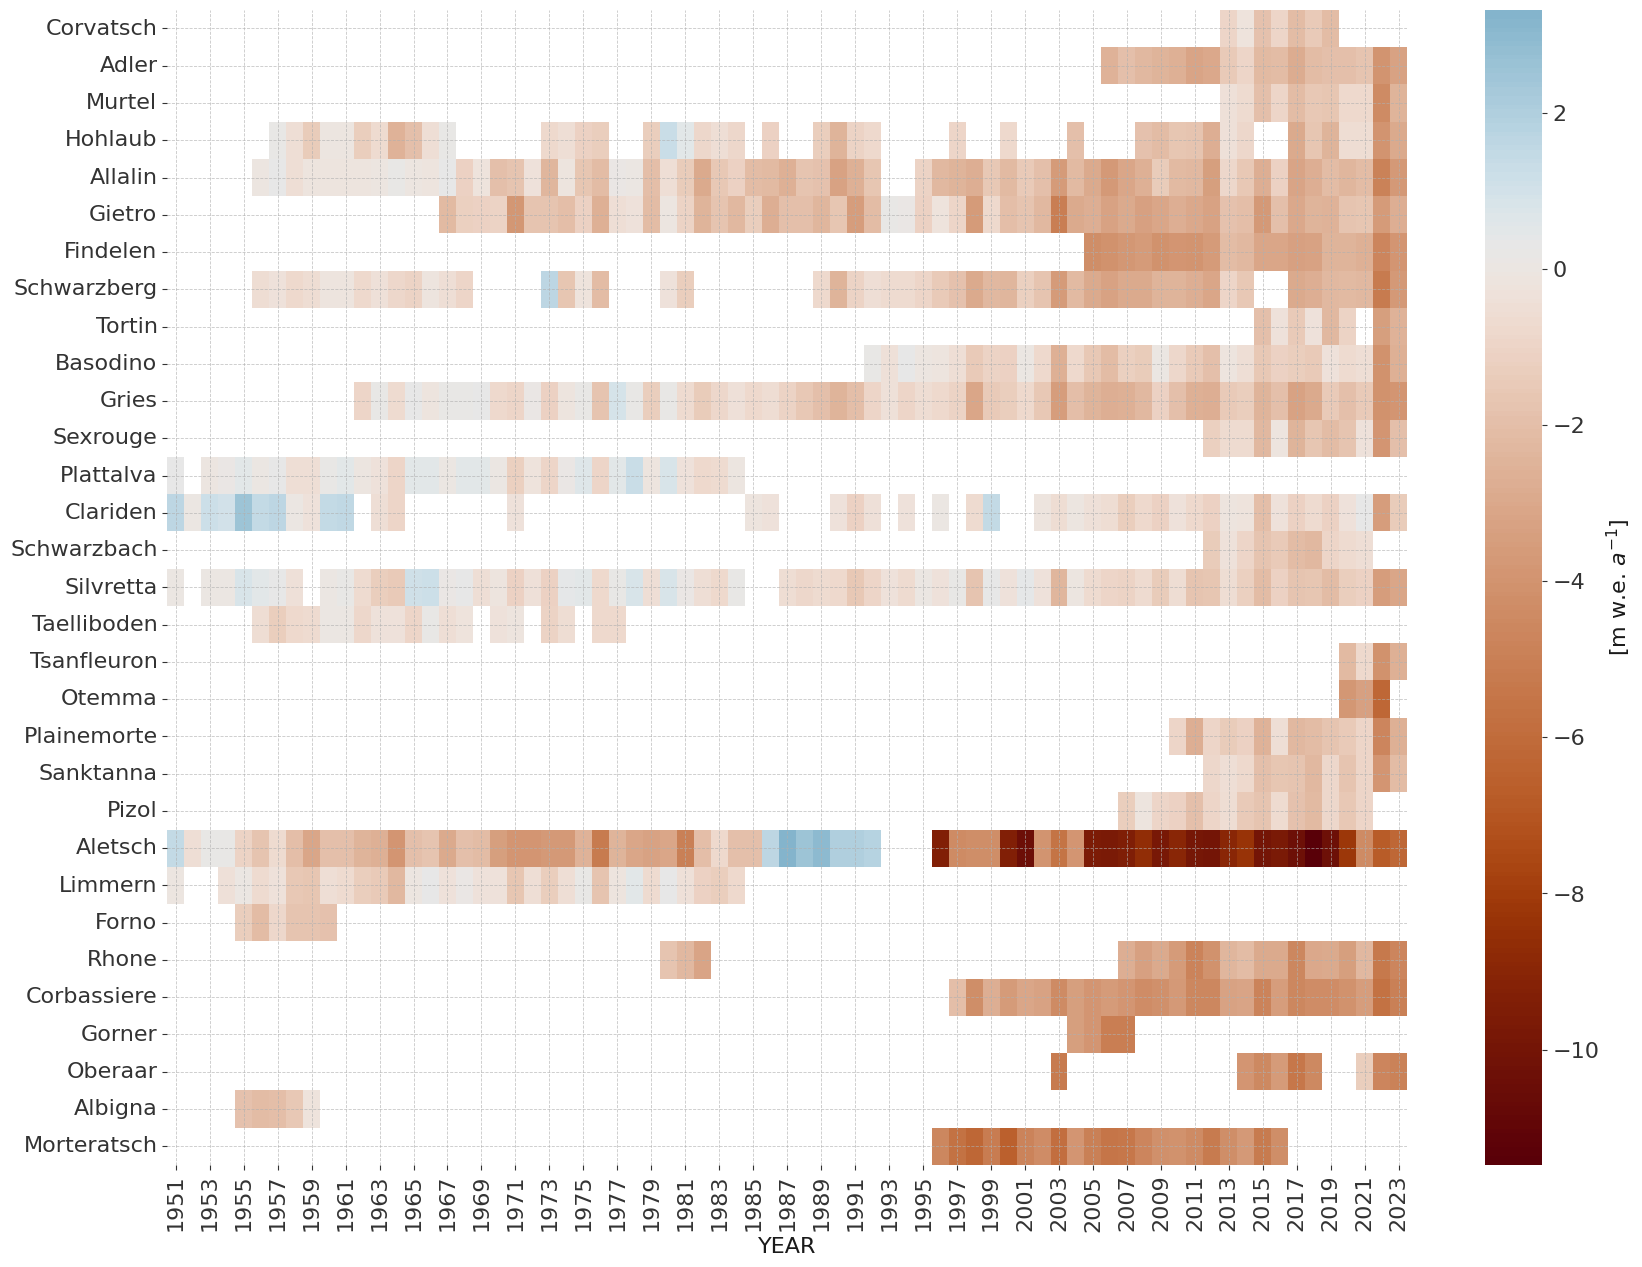

In [17]:
plotHeatmap(test_glaciers, data_glamos, glacierCap, period='annual')

#### Heatmap winter:

In [ ]:
plotHeatmap(test_glaciers, data_glamos, glacierCap, period='winter')

#### CV splits:

In [ ]:
splits, test_set, train_set = getCVSplits(dataloader_gl,
                                          test_split_on='GLACIER',
                                          test_splits=test_glaciers,
                                          random_state=cfg.seed)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))
visualiseSplits(test_set['y'], train_set['y'], splits)

visualiseInputs(train_set, test_set, vois_climate)

In [ ]:
# plot distributions of test glaciers:
f, ax = plt.subplots(len(test_glaciers),
                     len(vois_climate) + 3,
                     figsize=(16, 10),
                     sharey='row',
                     sharex='col')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[i, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[i, 0].set_title('PMB')
    ax[i, 0].set_ylabel(test_gl)
    ax[i, 0].set_xlabel('[m w.e.]')
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[i, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[i, 1].set_title('ELV_DIFF]')
    ax[i, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate + ['pcsr']):
        ax[i, 2 + j].set_title(voi_clim)
        test_df_gl[voi_clim].plot.hist(ax=ax[i, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[i, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()

In [ ]:
f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

In [ ]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
data_test.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
data_train.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

## XGBoost:

### Grid search:

In [ ]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

CORRECTED_VARS = True
if CORRECTED_VARS:
    vois_climate = [
        't2m_corr', 'tp_corr', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10',
        'v10'
    ]
else:
    vois_climate = [
        't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
    ]
# vois_topographical = [
#     "aspect_sgi",
#     "slope_sgi",
#     "hugonnet_dhdt",
#     "consensus_ice_thickness",
#     "millan_v",
# ]

vois_topographical = [
    "aspect_sgi",
    "slope_sgi",
    "hugonnet_dhdt",
    # "consensus_ice_thickness",
    # "millan_v",
]

In [ ]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # custom_xgboost.gridsearch(
    #     parameters=param_grid,
    #     splits=splits,
    #     features=df_X_train_subset,
    #     targets=train_set['y'],
    # )

    # save best model
    custom_xgboost.save_model(f'xgb_gl_split_sgi_corr.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_gl_split_sgi_corr.pkl')  # model with SGI aspect&slope

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))


In [ ]:
# visualiseValPreds(best_estimator, splits, train_set, feature_columns, cfg)

In [ ]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_, lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_, param_grid, lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_, param_grid, lossType=cfg.loss, N=10)

In [ ]:
FIPlot(best_estimator, feature_columns, vois_climate)

#### Predictions of best parameters:

In [ ]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()


### Predictions of custom parameters:

In [ ]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

In [ ]:
# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

In [ ]:
FIPlot(custom_model, feature_columns, vois_climate)

## Cumulative MB:

In [ ]:
df_metadata = pd.DataFrame(metadata_test, columns=cfg.metaData)
df_metadata = df_metadata.assign(y_pred=y_pred)

# separate into annual and winter
dfpred_annual = df_metadata[df_metadata['PERIOD'] == 'annual']
dfpred_winter = df_metadata[df_metadata['PERIOD'] == 'winter']

# plot distribution of predictions per month, one plot per month
f, ax = plt.subplots(3, 4, figsize=(20, 10), sharex=True)
for i, month in enumerate(month_abbr[1:]):
    dfpred_annual[dfpred_annual['MONTHS'] == month.lower()].y_pred.plot.hist(
        ax=ax.flatten()[i],
        color=color_annual,
        alpha=0.6,
        density=False,
        label='annual')
    if month.lower() in dfpred_winter.MONTHS.unique():
        dfpred_winter[dfpred_winter['MONTHS'] ==
                      month.lower()].y_pred.plot.hist(ax=ax.flatten()[i],
                                                      color=color_winter,
                                                      alpha=0.6,
                                                      density=False,
                                                      label='winter')
    ax.flatten()[i].set_title(month, fontsize=24)
    ax.flatten()[i].set_xlabel('[m w.e.]', fontsize=20)
    ax.flatten()[i].legend(fontsize=16)
    # add vertical line for 0 balance
    ax.flatten()[i].axvline(x=0, color='black', linestyle='--')
plt.tight_layout()

In [ ]:
# group ID to YEAR
ids_year_dict = test_set['df_X'][[
    'ID', 'YEAR'
]].groupby('ID')['YEAR'].unique().apply(list).to_dict()
ids_year_dict = {
    k: v[0] if len(v) == 1 else v
    for k, v in ids_year_dict.items()
}

In [ ]:
# Plot mean and std
fig, axs = plt.subplots(3, 3, figsize=(18, 15))
for i, test_gl in enumerate(test_glaciers):
    dfCumMB_all = cumulativeMB(dfpred_annual, test_gl, ids_year_dict, cfg.month_abbr_hydr)

    meanMB = pd.DataFrame(
        dfCumMB_all.groupby('months').cum_MB.mean()).reset_index()
    stdMB = pd.DataFrame(
        dfCumMB_all.groupby('months').cum_MB.std()).reset_index()

    meanMB['monthNb'] = meanMB['months'].apply(
        lambda x: month_abbr_hydr_full[x])
    stdMB['monthNb'] = stdMB['months'].apply(lambda x: month_abbr_hydr_full[x])
    # sort both by their monthNB
    meanMB = meanMB.sort_values(by='monthNb')
    stdMB = stdMB.sort_values(by='monthNb')

    ax = axs.flatten()[i]
    ax.plot(meanMB['months'].values, meanMB['cum_MB'], color='black')
    ax.fill_between(meanMB['months'].values,
                    meanMB['cum_MB'] - stdMB['cum_MB'],
                    meanMB['cum_MB'] + stdMB['cum_MB'],
                    color=color_dark_blue,
                    alpha=0.2)
    ax.set_title(f'Cumulative MB: {test_gl.capitalize()}')
    ax.set_ylabel('[m w.e.]')
    # add horizontal line for 0 balance
    ax.axhline(y=0, color='black', linestyle='--')
    # rotate xticks
    ax.set_xticklabels(meanMB.months, rotation=45)
plt.tight_layout()

In [ ]:
cmap = plt.cm.plasma_r

fig, axs = plt.subplots(3, 3, figsize=(18, 15))
for i, test_gl in enumerate(test_glaciers):
    ax = axs.flatten()[i]

    dfCumMB = cumulativeMB(dfpred_annual, test_gl, ids_year_dict, cfg.month_abbr_hydr)

    norm = plt.Normalize(dfCumMB['year'].min(), dfCumMB['year'].max())

    for year in dfCumMB['year'].unique():
        dfCumMB_year = dfCumMB[dfCumMB.year == year]

        meanMB = pd.DataFrame(
            dfCumMB_year.groupby('months').cum_MB.mean()).reset_index()
        stdMB = pd.DataFrame(
            dfCumMB_year.groupby('months').cum_MB.std()).reset_index()

        meanMB['monthNb'] = meanMB['months'].apply(
            lambda x: month_abbr_hydr_full[x])
        stdMB['monthNb'] = stdMB['months'].apply(
            lambda x: month_abbr_hydr_full[x])
        # sort both by their monthNB
        meanMB = meanMB.sort_values(by='monthNb')
        stdMB = stdMB.sort_values(by='monthNb')

        color = cmap(norm(year))
        ax.plot(meanMB['months'], meanMB['cum_MB'], color=color, label=year)
        ax.fill_between(meanMB['months'],
                        meanMB['cum_MB'] - stdMB['cum_MB'],
                        meanMB['cum_MB'] + stdMB['cum_MB'],
                        color=color,
                        alpha=0.2)

    # rotate xticks
    ax.set_xticklabels(month_abbr_hydr_full.keys(), rotation=45)

    ax.set_title(f'Cumulative MB: {test_gl.capitalize()}')
    ax.set_ylabel('[m w.e.]')

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for colorbar to work
    cbar = fig.colorbar(
        sm, ax=ax)  # Attach the colorbar to the figure and the specific axis
    cbar.set_label('Year')

plt.tight_layout()

## Extrapolate in space


### Geodetic MB:

In [ ]:
# read geodetic MB:
geodeticMB = pd.read_csv(path_geodetic_MB_glamos + 'dV_DOI2024_allcomb.csv')

# filter to glaciers
all_gl = dataloader_gl.data.GLACIER.unique()

# get rgi of those glaciers:
rgi_gl = data_glamos[data_glamos.GLACIER.isin(all_gl)].RGIId.unique()
sgi_gl = [
    rgi_df[rgi_df['rgi_id.v6'] == rgi]['sgi-id'].values[0] for rgi in rgi_gl
]
geodeticMB = geodeticMB[geodeticMB['SGI-ID'].isin(sgi_gl)]

# Add glacierName to geodeticMB
# based  on SGI-ID
glacierNames = [
    rgi_df[rgi_df['sgi-id'] == sgi_id].index[0]
    for sgi_id in geodeticMB['SGI-ID'].values
]
geodeticMB['glacierName'] = glacierNames

# replace claridenL by clariden
geodeticMB['glacierName'] = geodeticMB['glacierName'].apply(
    lambda x: 'clariden' if x == 'claridenL' else x)

# get years per glacier
years_start_per_gl = geodeticMB.groupby(
    'glacierName')['Astart'].unique().apply(list).to_dict()
years_end_per_gl = geodeticMB.groupby('glacierName')['A_end'].unique().apply(
    list).to_dict()
years_end_per_gl


In [ ]:
periods_per_glacier = defaultdict(list)
geoMB_per_glacier = defaultdict(list)
# Iterate through the DataFrame rows
for _, row in geodeticMB.iterrows():
    glacierName = row['glacierName']
    start_year = row['Astart']
    end_year = row['A_end']
    geoMB = row['Bgeod']

    # Append the (start, end) tuple to the glacier's list
    periods_per_glacier[glacierName].append((start_year, end_year))
    geoMB_per_glacier[glacierName].append(geoMB)

# Plot an example
# Plot geodetic MB of silvretta for all periods
glacierName = 'silvretta'
periods = periods_per_glacier[glacierName]
geoMB = geoMB_per_glacier[glacierName]

fig, ax = plt.subplots(figsize=(10, 5))
for i, period in enumerate(periods):
    ax.plot(period, [geoMB[i], geoMB[i]], label=f'Period {i+1}')
ax.set_title(f'Geodetic MB of {glacierName.capitalize()}')

### Glacier wide MB: 
Compute 2D fields to compare wtih years that have Sentinel data.

In [ ]:
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_pcsr+'csv/')
]
glDirect.sort()

data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]

glacier_list = list(data_glamos.GLACIER.unique())

print('Number of glaciers:', len(glacier_list))
glacier_list.sort()

In [ ]:
def find_processed_and_incomplete_glaciers(folder_path, all_glaciers):
    """
    Identifies glaciers that are fully processed and those with missing years.

    Parameters:
        folder_path (str): Path to the folder containing the files.
        all_glaciers (list): List of all glaciers that need to be processed.

    Returns:
        tuple: A list of fully processed glaciers and a dictionary of incomplete glaciers with missing years.
    """
    processed_years = defaultdict(set)

    # Regular expression to match the filename format
    pattern = re.compile(
        r'^(?P<glacier>[a-zA-Z_]+)_grid_(?P<year>\d{4})\.csv$')

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        match = pattern.match(filename)
        if match:
            glacier = match.group('glacier')
            year = int(match.group('year'))
            if 2000 <= year <= 2023:
                processed_years[glacier].add(year)

    fully_processed = []
    incomplete_glaciers = {}

    # Check for completeness for each glacier
    for glacier in all_glaciers:
        all_years = set(range(2000, 2023))
        if glacier in processed_years:
            missing_years = all_years - processed_years[glacier]
            if not missing_years:
                fully_processed.append(glacier)
            else:
                incomplete_glaciers[glacier] = sorted(missing_years)
        else:
            incomplete_glaciers[glacier] = sorted(all_years)

    return fully_processed, incomplete_glaciers


fully_processed, incomplete_glaciers = find_processed_and_incomplete_glaciers(
    path_glacier_grid_sgi, glacier_list)
fully_processed, incomplete_glaciers

In [ ]:
satellite_glaciers = [
    'adler', 'aletsch', 'allalin', 'basodino', 'clariden', 'findelen', 'gries',
    'hohlaub', 'limmern', 'oberaar', 'plattalva', 'rhone', 'sanktanna',
    'schwarzbach', 'schwarzberg'
]
geodetic_glaciers = geodeticMB.glacierName.unique()

# join the two lists and remove duplicates
all_glaciers = list(set(satellite_glaciers + list(geodetic_glaciers)))

# keep only glaciers that have a computed SGI grid
all_glaciers = [gl for gl in all_glaciers if gl in fully_processed]
all_glaciers.sort()

# Load the shapefile
# Read rgi ids:
path_glacier_ids = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_glacier_ids, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
shapefile_path = "../../../data/GLAMOS/topo/SGI_2016_glaciers_copy.shp"
gdf_shapefiles = gpd.read_file(shapefile_path)

# Order glaciers by size:
gl_area = {}
for glacierName in all_glaciers:
    if glacierName == 'clariden':
        sgi_id = rgi_df[rgi_df.short_name ==
                        'claridenU']['sgi-id'].values[0].strip()
        rgi_shp = rgi_df[rgi_df.short_name ==
                         'claridenU']['rgi_id_v6_2016_shp'].values[0]
    else:
        sgi_id = rgi_df[rgi_df.short_name ==
                        glacierName]['sgi-id'].values[0].strip()
        rgi_shp = rgi_df[rgi_df.short_name ==
                         glacierName]['rgi_id_v6_2016_shp'].values[0]

    # 2016 shapefile of glacier
    gdf_mask_gl = gdf_shapefiles[gdf_shapefiles.RGIId == rgi_shp]
    gl_area[glacierName] = gdf_mask_gl.Area.values[0]

gl_area = sorted(gl_area, key=lambda x: gl_area[x], reverse=False)
gl_area

### SGI grids:

In [ ]:
RUN = True
if RUN:
    #path_save = 'results/nc/sgi_corr/'
    path_save = 'results/nc/sgi_topo_simple/'
    # EMPTY = True
    # if EMPTY:
    #     emptyfolder(path_save)
    #     remaining_gl = all_glaciers
    # else:
    #     already_processed = os.listdir(path_save)
    #     remaining_gl = Diff(already_processed, gl_area)
    #     remaining_gl.sort()

    #emptyfolder(path_save)
    # Feature columns:
    feature_columns = [
        'ELEVATION_DIFFERENCE'
    ] + list(vois_climate) + list(vois_topographical) + ['pcsr']
    all_columns = feature_columns + cfg.fieldsNotFeatures

    print('Running for features columns:', all_columns)

    for glacierName in tqdm(gl_area, desc='Glaciers'):
        print(glacierName)
        for year in tqdm(range(2000, 2024), desc='Years', leave=False):
            df_grid_monthly = pd.read_csv(path_glacier_grid_sgi +
                                          f'{glacierName}_grid_{year}.csv')

            # Correct climate grids:
            df_grid_monthly = correct_vars_grid(df_grid_monthly)

            # Rename aspect and slope to sgi
            df_grid_monthly.rename(columns={
                'aspect': 'aspect_sgi',
                'slope': 'slope_sgi'
            },
                                   inplace=True)
            df_grid_monthly['POINT_ELEVATION'] = df_grid_monthly['topo']
            df_grid_monthly.drop_duplicates(inplace=True)  # remove duplicates
            df_grid_monthly = df_grid_monthly[all_columns]

            # Add cumulative monthly SMB:
            df_grid_monthly = custom_model.cumulative_pred(df_grid_monthly)

            # Seasonal predictions:
            grouped_ids_annual = GlacierWidePred(custom_model,
                                                 df_grid_monthly[all_columns],
                                                 type_pred='annual')

            grouped_ids_winter = GlacierWidePred(custom_model,
                                                 df_grid_monthly[all_columns],
                                                 type_pred='winter')

            # Annual SMB:
            pred_y_annual = grouped_ids_annual[grouped_ids_annual.YEAR ==
                                               year].drop(['YEAR'], axis=1)
            # Winter SMB:
            pred_y_winter = grouped_ids_winter[grouped_ids_winter.YEAR ==
                                               year].drop(['YEAR'], axis=1)

            # if doesn't exist skip:
            if not os.path.exists(path_SGI_topo + 'xr_masked_grids/' +
                                  f'{glacierName}.nc'):
                continue

            ds = xr.open_dataset(path_SGI_topo + 'xr_masked_grids/' +
                                 f'{glacierName}.nc')

            geoData = mbm.GeoData(pred_y_annual)
            geoData.pred_to_xr(ds, pred_var='pred', source_type='sgi')
            filename = f"{glacierName}_{year}_annual.nc"
            geoData.save_arrays(filename,
                                path=path_save + f"{glacierName}/",
                                proj_type='wgs84')

            geoData = mbm.GeoData(pred_y_winter)
            geoData.pred_to_xr(ds, pred_var='pred', source_type='sgi')
            filename = f"{glacierName}_{year}_winter.nc"
            geoData.save_arrays(filename,
                                path=path_save + f"{glacierName}/",
                                proj_type='wgs84')

            # Save monthly grids:
            for i, month in enumerate(config.month_abbr_hydr.keys()):
                # Only do spring and summer months because otherwise no satelitte data
                if month in ['sep_', 'oct', 'nov', 'dec', 'jan', 'feb']:
                    continue
                monthNb = config.month_abbr_hydr[month]
                df_grid_gl_m = df_grid_monthly[df_grid_monthly['MONTHS'] ==
                                               month]

                # Get in format for map:
                df_grid_gl_m = df_grid_gl_m.groupby('ID').agg({
                    'YEAR':
                    'mean',
                    'POINT_LAT':
                    'mean',
                    'POINT_LON':
                    'mean',
                    'pred':
                    'mean',
                    'cum_pred':
                    'mean'
                })
                pred_y = df_grid_gl_m.drop(['YEAR'], axis=1)
                geoData = mbm.GeoData(pred_y)
                geoData.pred_to_xr(ds, pred_var='cum_pred', source_type='sgi')
                filename = f"{glacierName}_{year}_{monthNb}.nc"
                geoData.save_arrays(filename,
                                    path=path_save + f"{glacierName}/",
                                    proj_type='wgs84')

In [ ]:
# open xarray
xr.open_dataset(path_save +
                'aletsch/aletsch_2023_annual.nc').pred_masked.plot()

### GLAMOS grids:

In [ ]:
os.listdir(path_xr_grids)

In [ ]:
# path_save_glamos = 'results/nc/glamos_corr/'
path_save_glamos = 'results/nc/glamos_topo_simple/'
createPath(path_save_glamos)
emptyfolder(path_save_glamos)

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + cfg.fieldsNotFeatures

print('Running for features columns:', all_columns)

path_glacier_grid_glamos = '../../../data/GLAMOS/topo/gridded_topo_inputs/GLAMOS_yearly/'
path_xr_grids = '../../../data/GLAMOS/topo/GLAMOS_DEM/xr_masked_grids/'

for glacierName in tqdm(gl_area, desc='Processing glaciers'):
    # all files with that glacier in path
    files = [
        f for f in os.listdir(path_glacier_grid_glamos) if glacierName in f
    ]
    print(glacierName)
    for fileName in tqdm(files, desc='files', leave=False):
        year = int(fileName.split('_')[2].split('.')[0])

        df_grid_monthly = pd.read_csv(path_glacier_grid_glamos +
                                      f'{glacierName}_grid_{year}.csv')

        # Correct climate grids:
        df_grid_monthly = correct_vars_grid(df_grid_monthly)

        # Rename aspect and slope to sgi
        df_grid_monthly.rename(columns={
            'aspect': 'aspect_sgi',
            'slope': 'slope_sgi'
        },
                               inplace=True)
        df_grid_monthly['POINT_ELEVATION'] = df_grid_monthly['topo']
        df_grid_monthly.drop_duplicates(inplace=True)  # remove duplicates
        df_grid_monthly = df_grid_monthly[all_columns]

        # Add cumulative monthly SMB:
        df_grid_monthly = custom_model.cumulative_pred(df_grid_monthly)

        # Seasonal predictions:
        grouped_ids_annual = GlacierWidePred(custom_model,
                                             df_grid_monthly[all_columns],
                                             type_pred='annual')

        grouped_ids_winter = GlacierWidePred(custom_model,
                                             df_grid_monthly[all_columns],
                                             type_pred='winter')

        # Annual SMB:
        pred_y_annual = grouped_ids_annual[grouped_ids_annual.YEAR ==
                                           year].drop(['YEAR'], axis=1)
        # Winter SMB:
        pred_y_winter = grouped_ids_winter[grouped_ids_winter.YEAR ==
                                           year].drop(['YEAR'], axis=1)

        # Open glacier DEM for that year
        # if doesn't exist skip:
        if not os.path.exists(path_xr_grids + f'{glacierName}_{year}.nc'):
            continue
        ds = xr.open_dataset(path_xr_grids + f'{glacierName}_{year}.nc')

        geoData = mbm.GeoData(pred_y_annual)
        geoData.pred_to_xr(ds, pred_var='pred', source_type='sgi')
        filename = f"{glacierName}_{year}_annual.nc"
        geoData.save_arrays(filename,
                            path=path_save_glamos + f"{glacierName}/",
                            proj_type='wgs84')

        geoData = mbm.GeoData(pred_y_winter)
        geoData.pred_to_xr(ds, pred_var='pred', source_type='sgi')
        filename = f"{glacierName}_{year}_winter.nc"
        geoData.save_arrays(filename,
                            path=path_save_glamos + f"{glacierName}/",
                            proj_type='wgs84')

        # Save monthly grids:
        for i, month in enumerate(config.month_abbr_hydr.keys()):
            # Only do spring and summer months because otherwise no satelitte data
            if month in ['sep_', 'oct', 'nov', 'dec', 'jan', 'feb']:
                continue
            monthNb = config.month_abbr_hydr[month]
            df_grid_gl_m = df_grid_monthly[df_grid_monthly['MONTHS'] == month]

            # Get in format for map:
            df_grid_gl_m = df_grid_gl_m.groupby('ID').agg({
                'YEAR': 'mean',
                'POINT_LAT': 'mean',
                'POINT_LON': 'mean',
                'pred': 'mean',
                'cum_pred': 'mean'
            })
            pred_y = df_grid_gl_m.drop(['YEAR'], axis=1)
            geoData = mbm.GeoData(pred_y)
            geoData.pred_to_xr(ds, pred_var='cum_pred', source_type='sgi')
            filename = f"{glacierName}_{year}_{monthNb}.nc"
            geoData.save_arrays(filename,
                                path=path_save_glamos + f"{glacierName}/",
                                proj_type='wgs84')


In [ ]:
# open xarray
xr.open_dataset(path_save_glamos +
                'aletsch/aletsch_2023_annual.nc').pred_masked.plot()